In [2]:
import sys
import torch
from Scripts.model import UNetv1, UNetv2
from torch.utils.data import DataLoader
from Utils.diffusion_utils import DiffusionUtils
import matplotlib.pyplot as plt
import torch.nn.functional as F
from Utils.helper_functions import load_transformed_FashionMNIST, load_transformed_MNIST
from Scripts.embedding_blocks import ClassEmbeddingBlock

In [3]:
IMG_SIZE = 16
NUM_CLASSES = 10
IMG_CHANNELS = 1
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

start = 0.0001
end = 0.02
T = 150
EPOCHS = 3

dataloader = DataLoader(load_transformed_FashionMNIST(IMG_SIZE), batch_size=128, shuffle=True, drop_last=True)
utils = DiffusionUtils(start, end, diffusion_time=T, device=device)

model = UNetv2(IMG_CHANNELS, NUM_CLASSES, down_chs=(16, 32, 64)).to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [4]:
class_names = [
    "Top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [5]:
@torch.no_grad()
def sample_images(n_cols, T, class_, w):
    intervals = int(T/n_cols)
    fig = plt.figure(figsize=(20,5))
    i=1
    class_embedder = ClassEmbeddingBlock(10)
    x_t = torch.randn((1, 1, IMG_SIZE, IMG_SIZE)).to(device)
    for t in range(0, T)[::-1]:
        time = torch.tensor([[t]]).to(device)
        class_ = torch.tensor([class_]).to(device)
        e_t = utils.predict_class_noise(model, x_t, time, class_embedder(class_, False), w)
        x_t = utils.reverse_diffusion(x_t, e_t, time, random_init=True)
        if t % n_cols == 0:
            ax = fig.add_subplot(1, intervals, i)
            ax.imshow(x_t.squeeze().cpu().numpy())
            ax.axis('off')
            i += 1
    plt.suptitle(class_names[class_])
    plt.tight_layout()
    plt.show()

## Using large positive value of w weights the model towards the most representative images of the prompted class

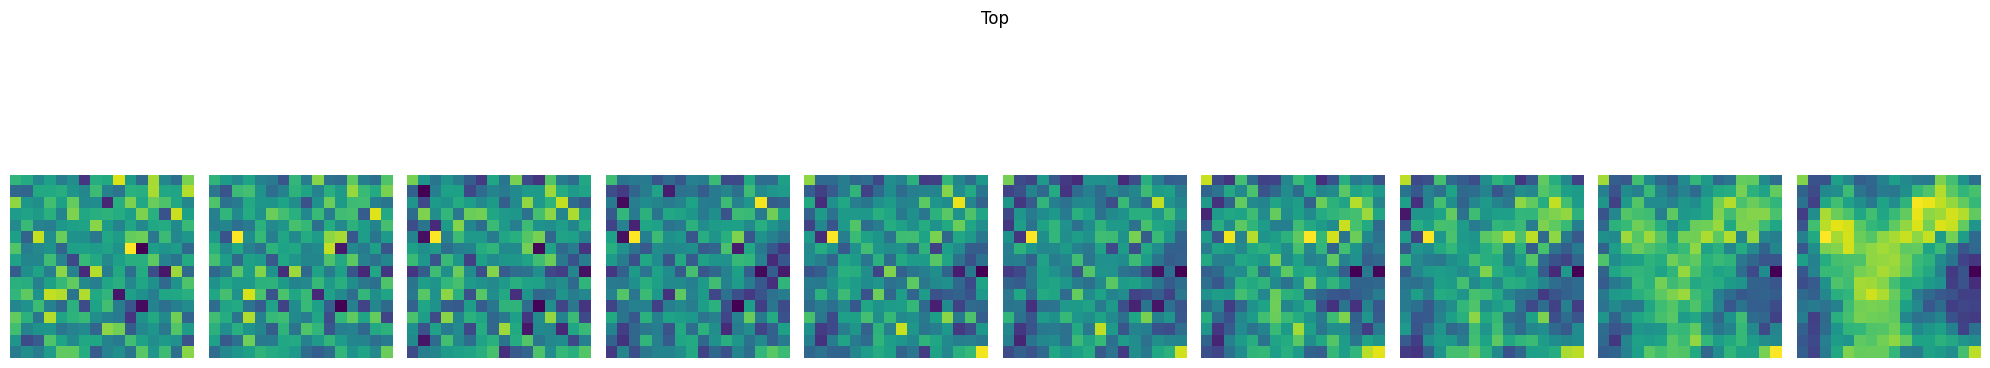

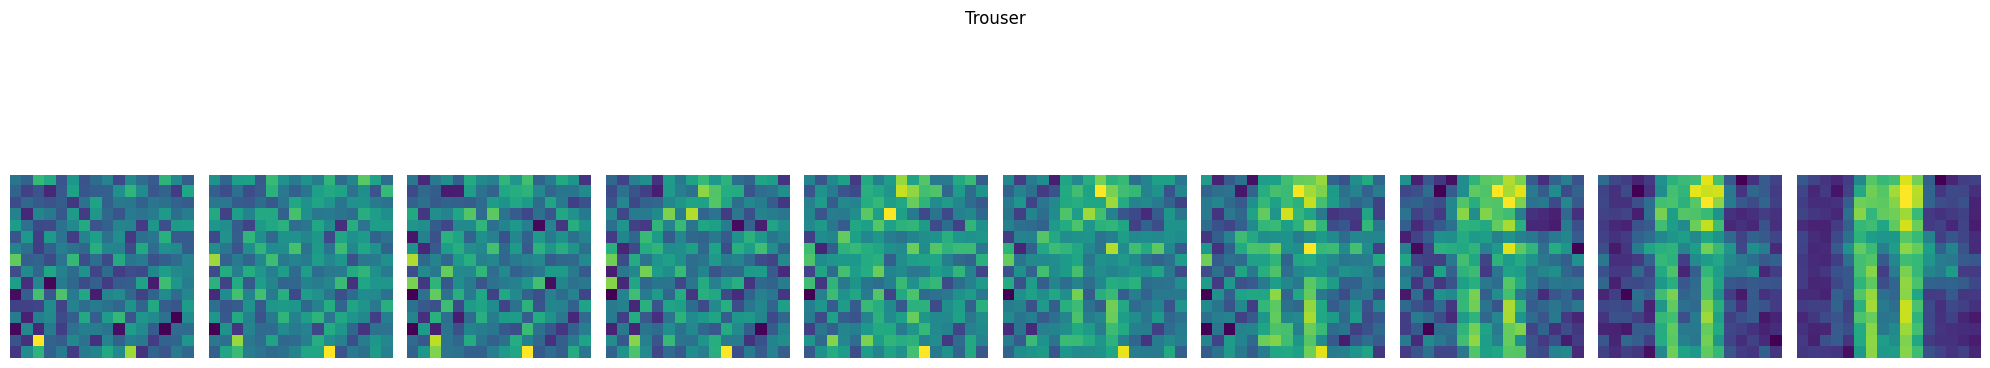

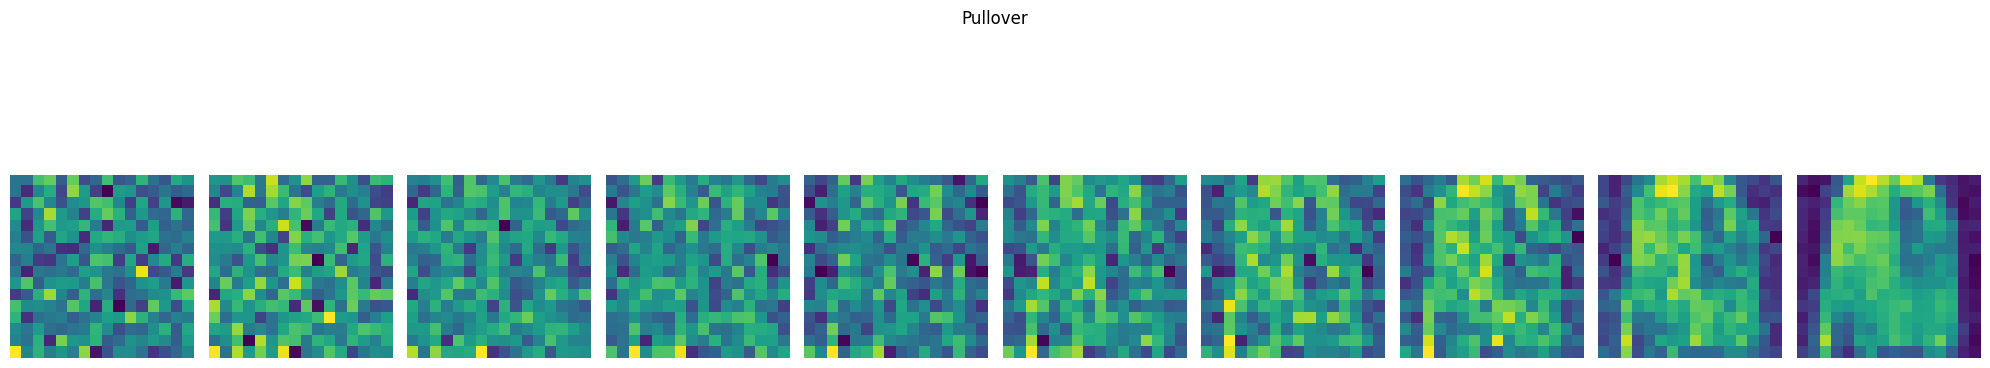

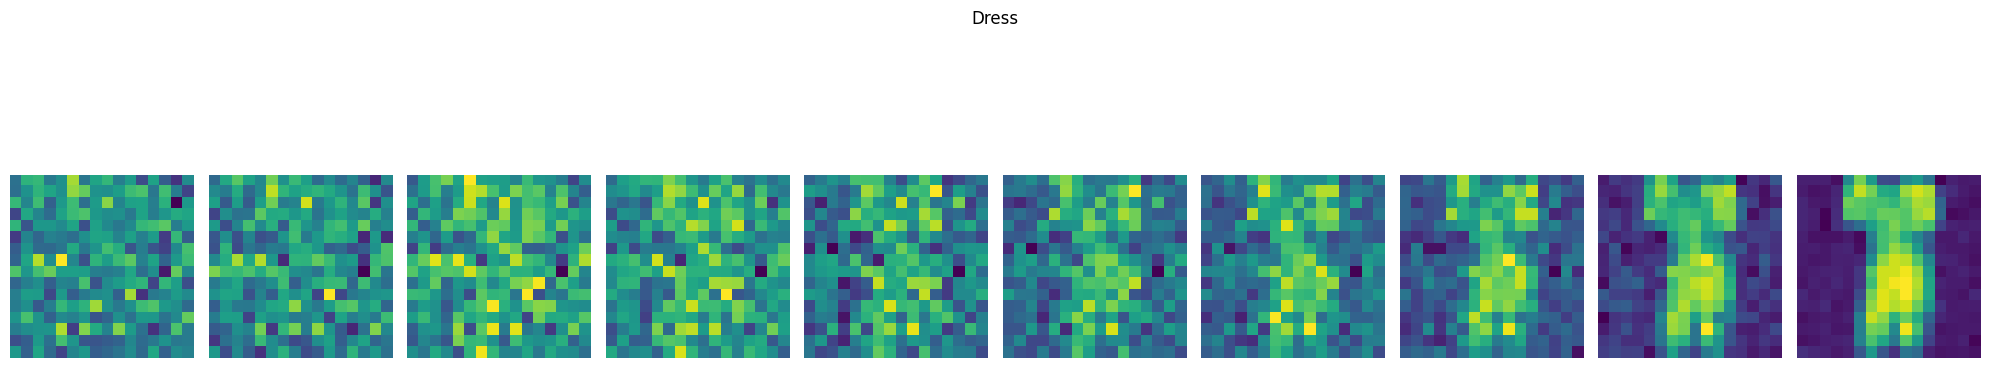

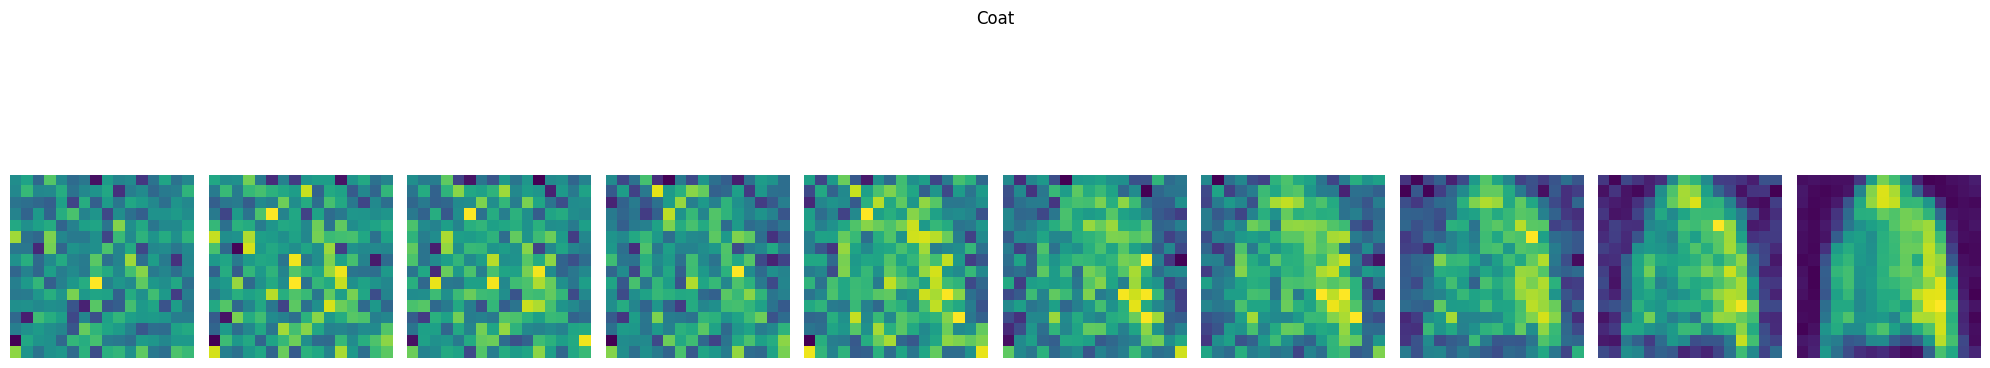

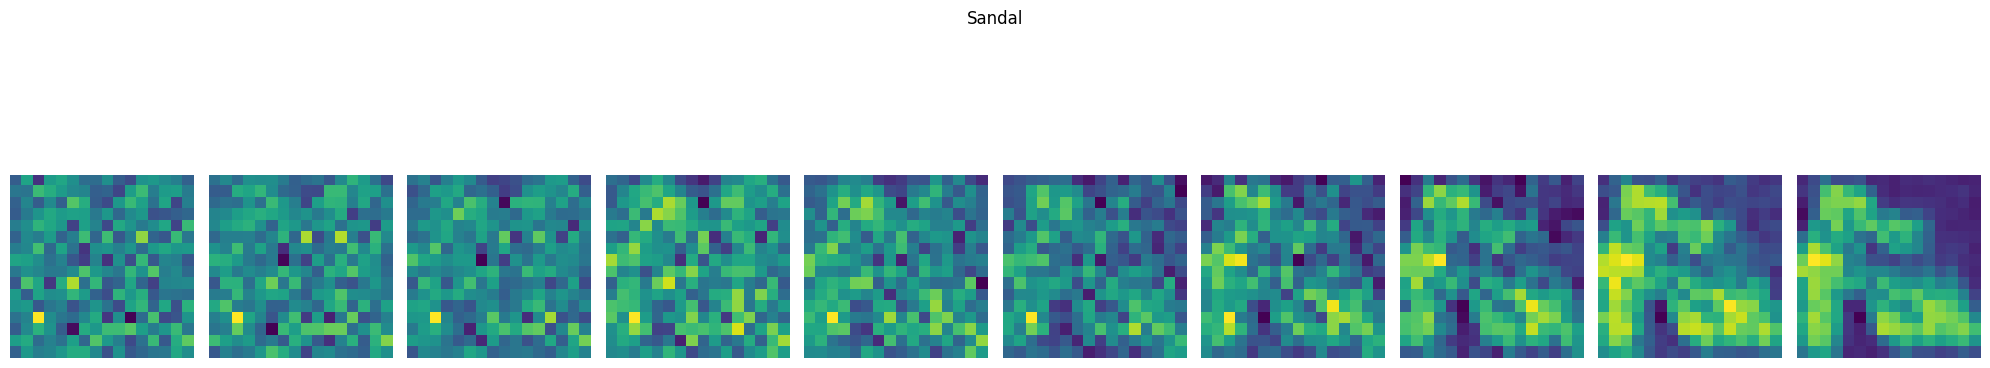

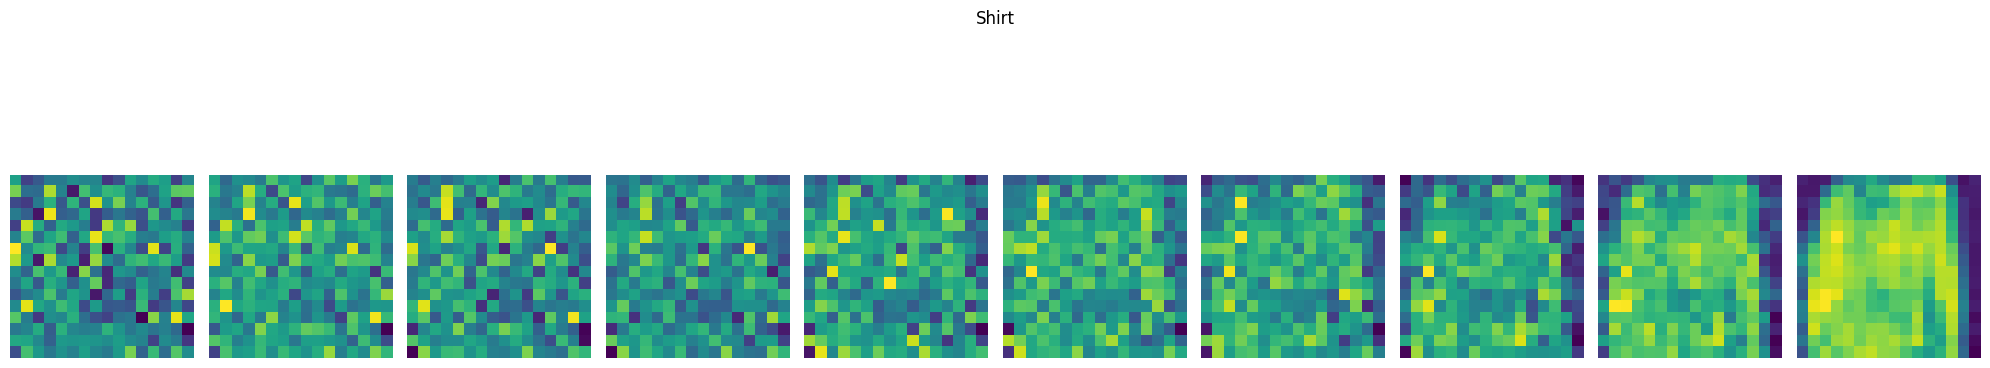

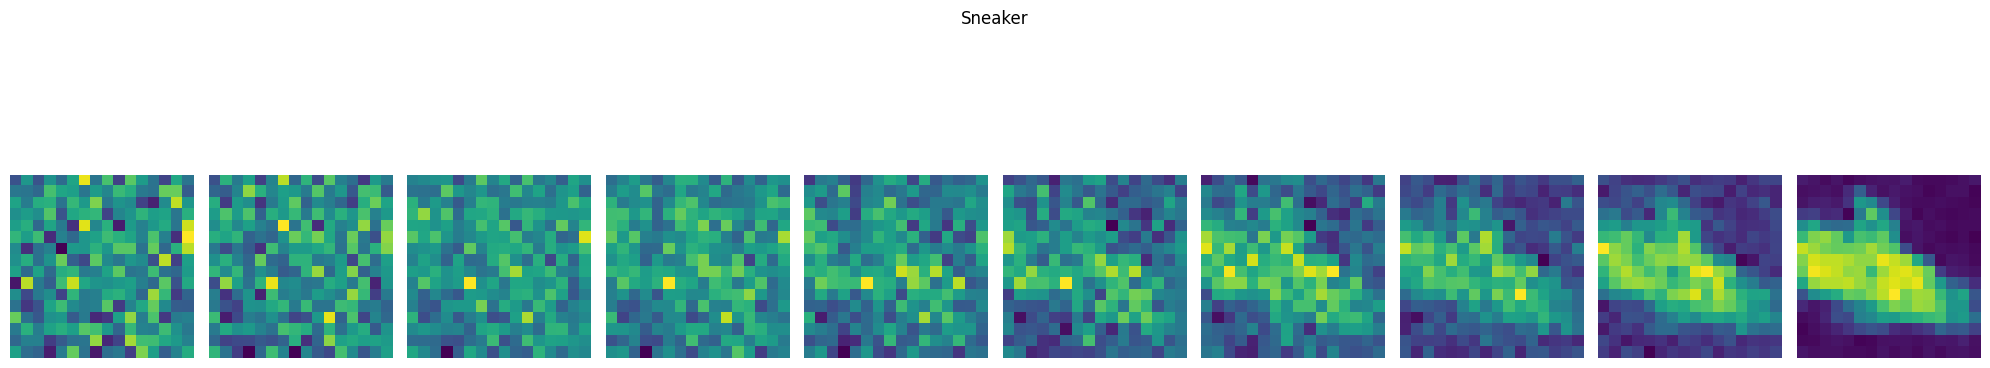

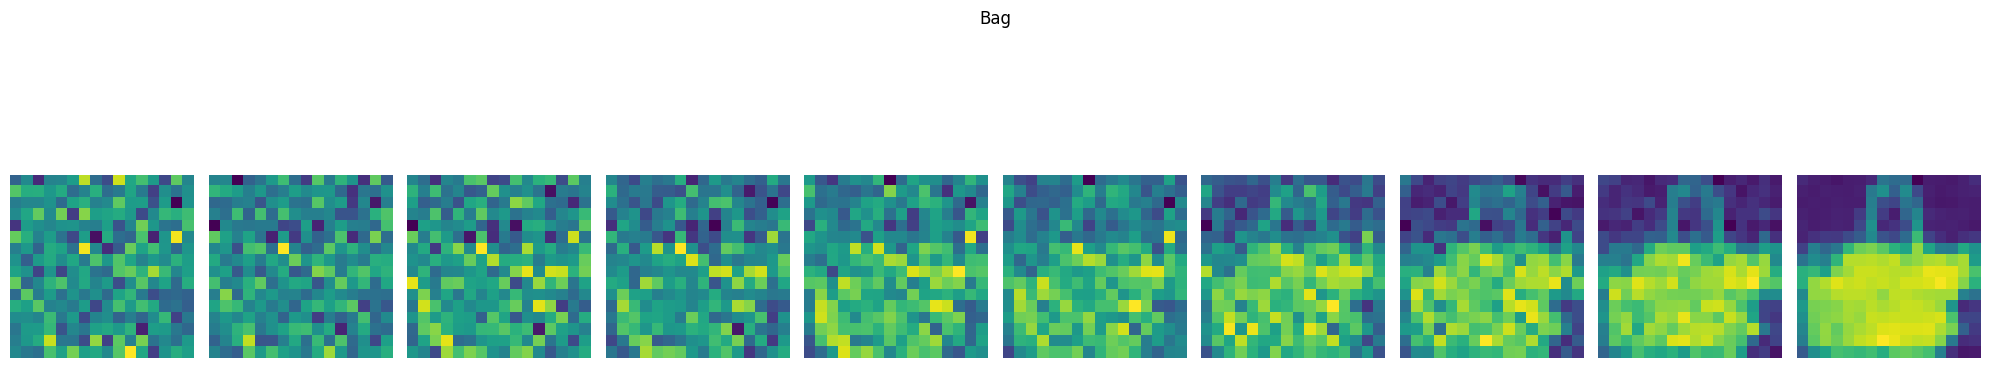

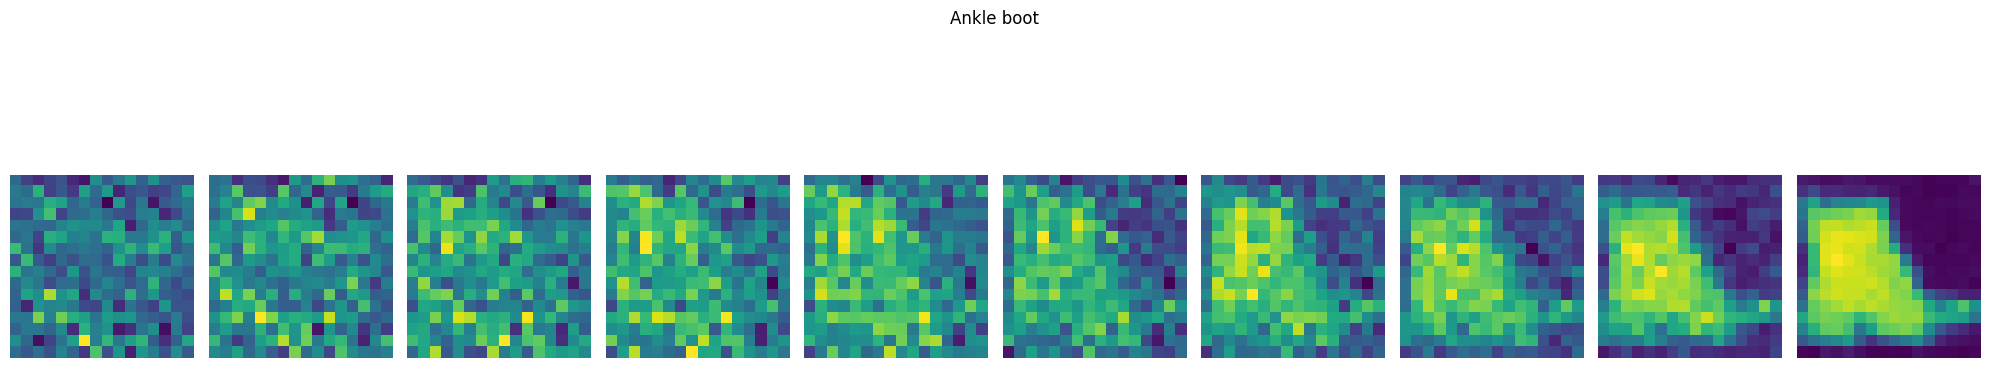

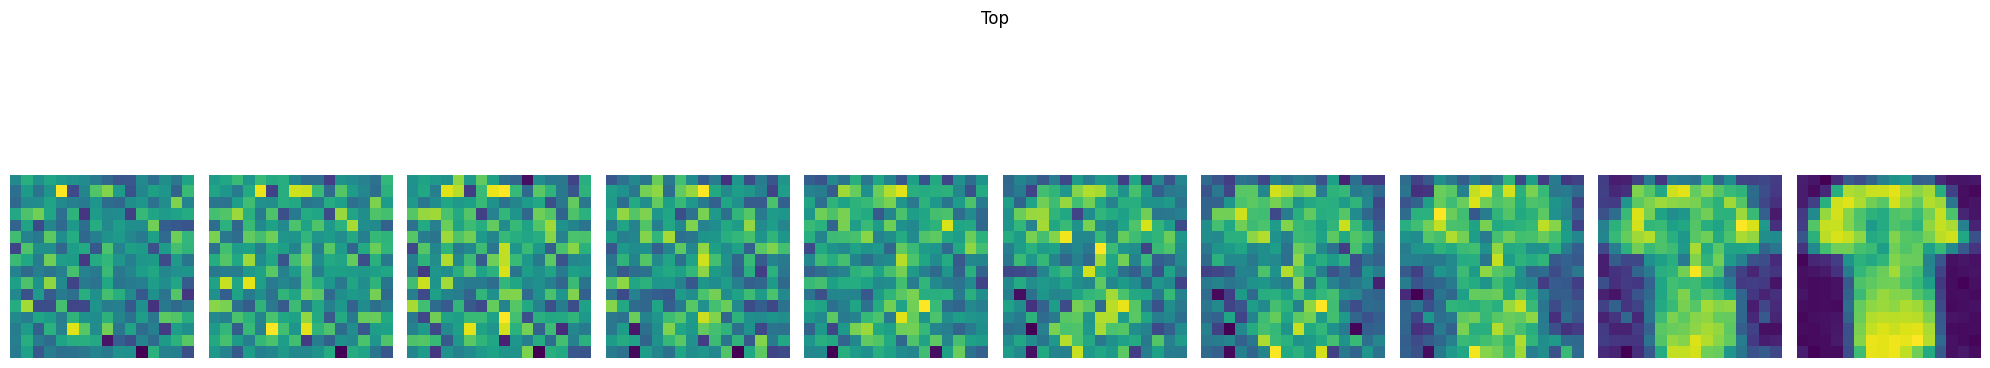

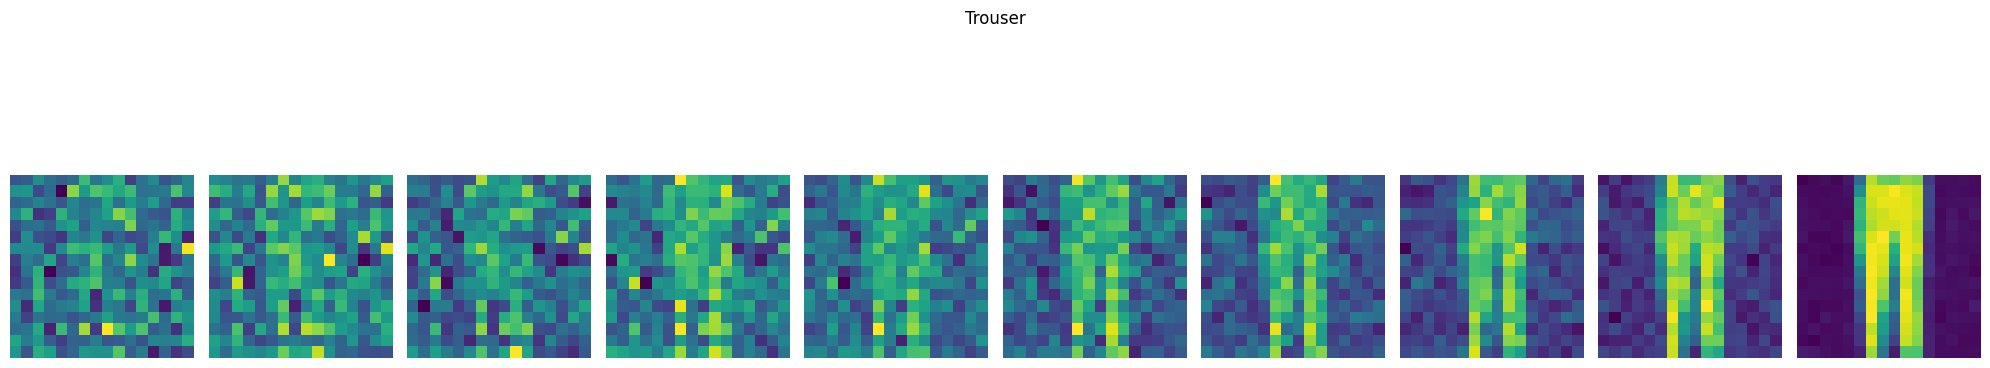

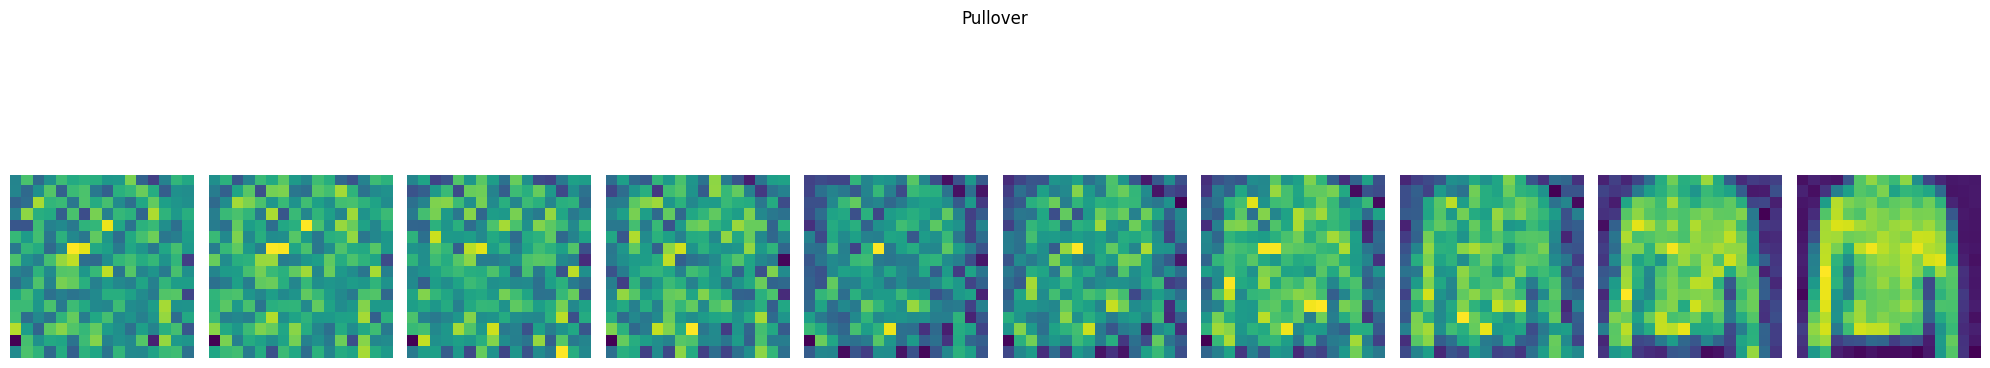

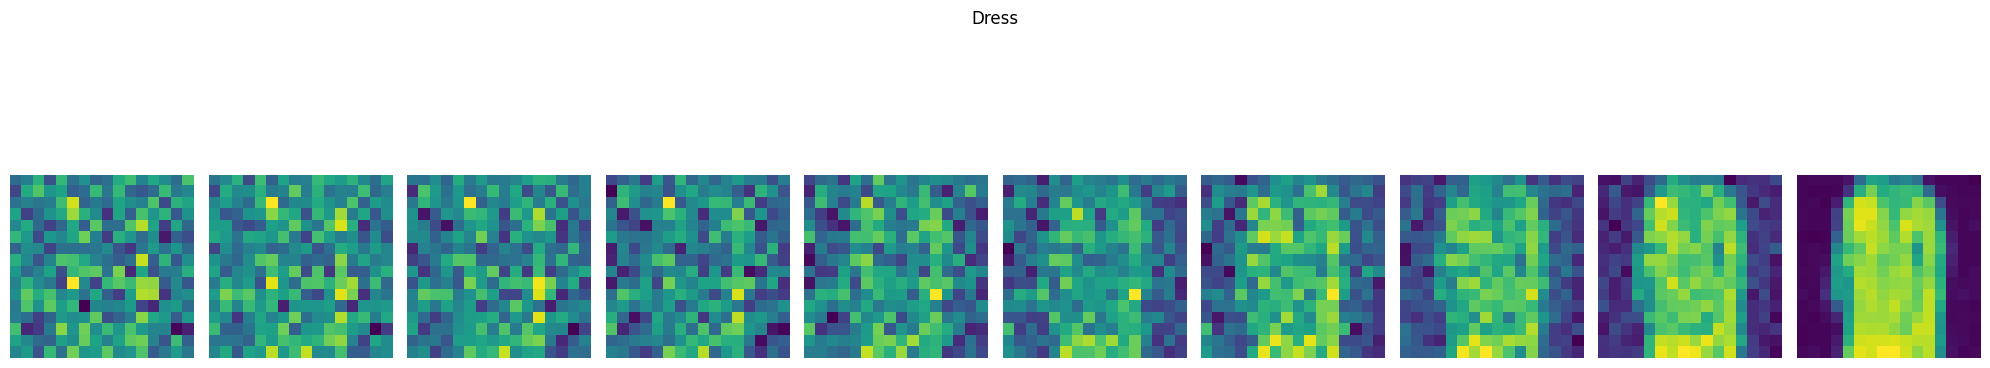

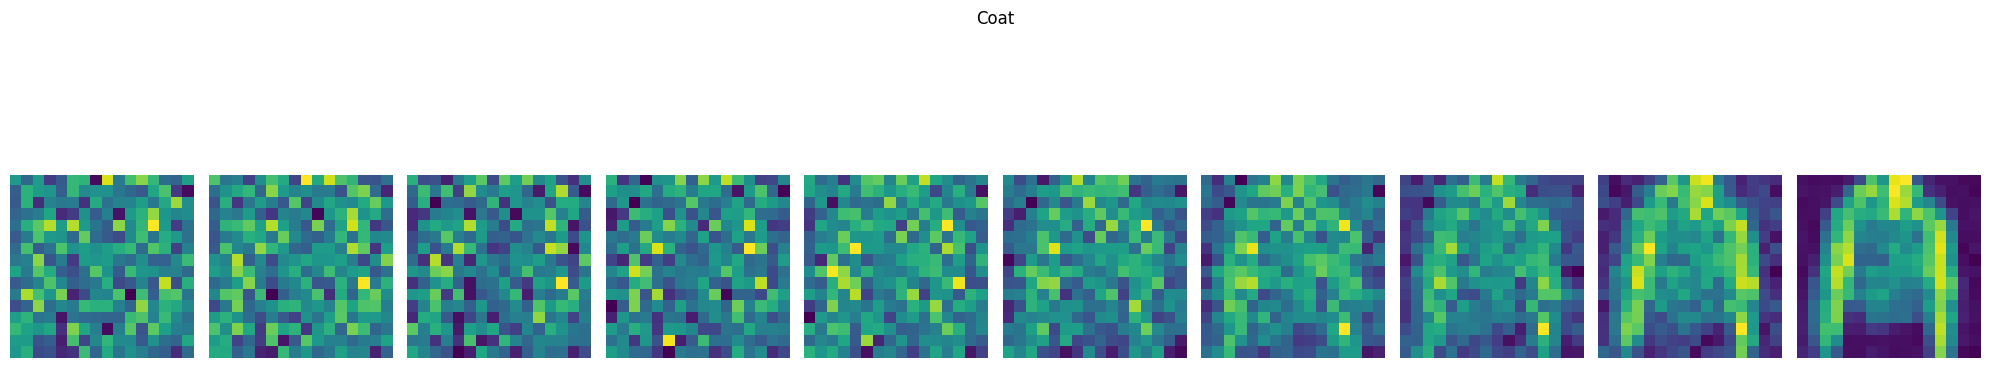

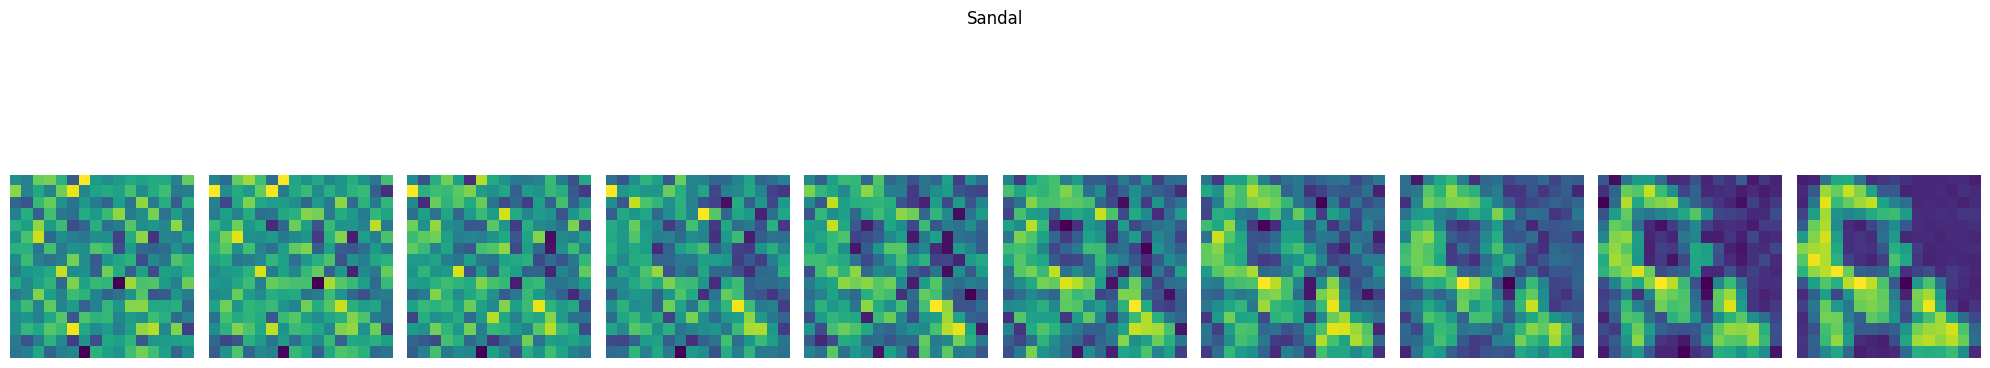

In [11]:
i = 1
total_loss = 0
class_ = 0
class_embedder = ClassEmbeddingBlock(10)

for epoch in range(EPOCHS):
    for (x_batch, classes) in dataloader:
        optimizer.zero_grad()

        x_batch = x_batch.to(device)
        classes = classes.to(device)
        rand_times = torch.randint(0, T, (x_batch.shape[0], 1)).to(device)
        noisy_images, noise = utils.forward_diffusion(x_batch, rand_times.squeeze())

        pred_noise = model(noisy_images, rand_times, class_embedder(classes))
        loss = F.mse_loss(noise, pred_noise)

        loss.backward()
        optimizer.step()
        i += 1
        total_loss += loss.item()

        if i % 100 == 0:
            sample_images(15, T, class_, 3)
            class_ += 1
            if class_ > 9:
                class_ = 0

## Using a negative value of w weights the model more towards generating "mean" images instead of prompted class

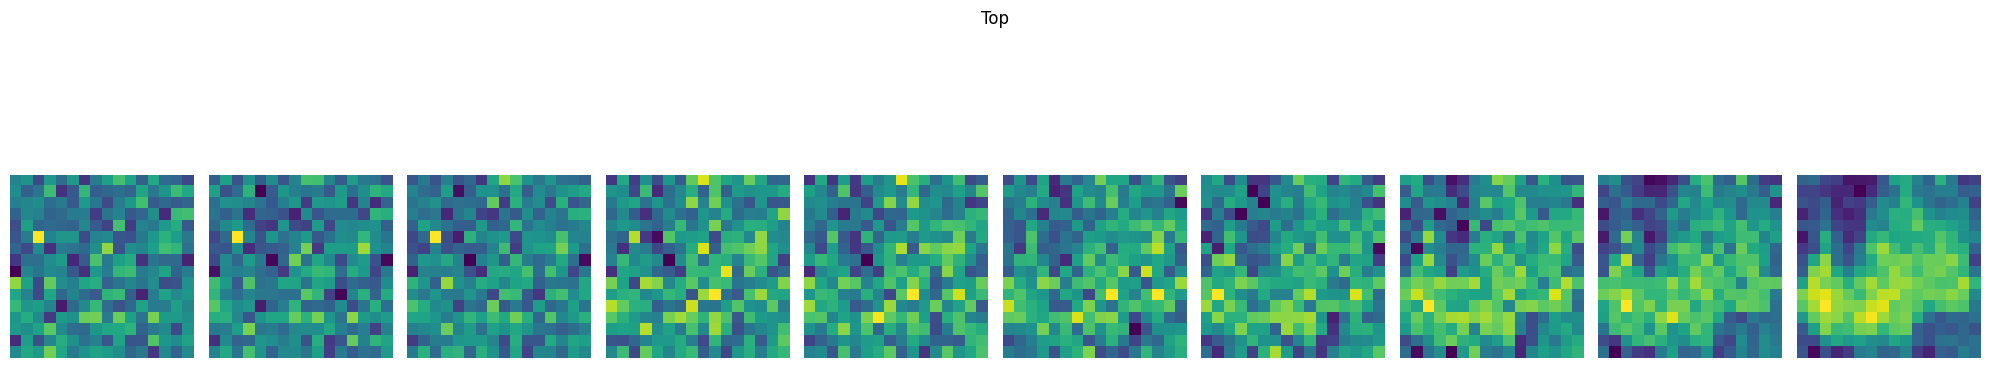

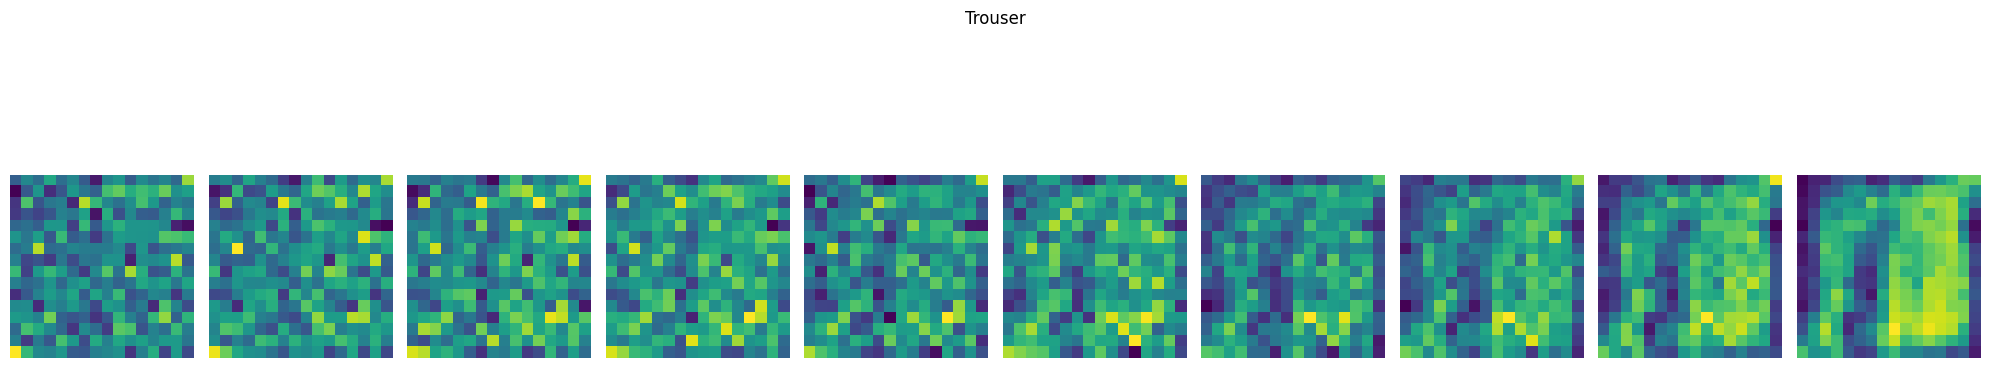

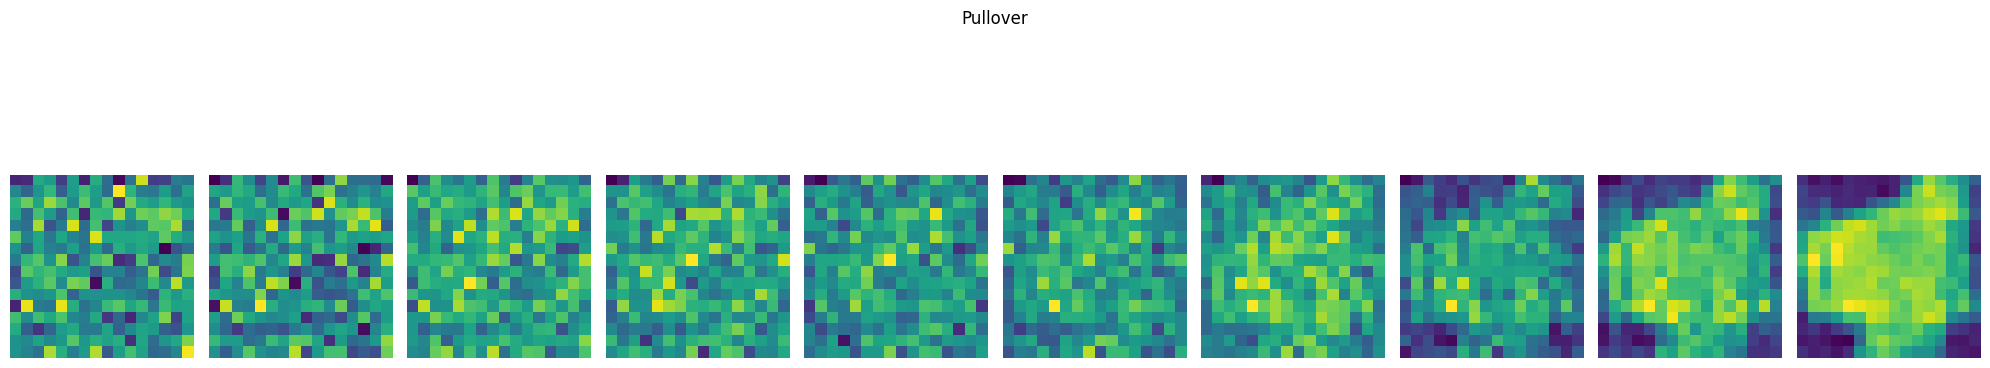

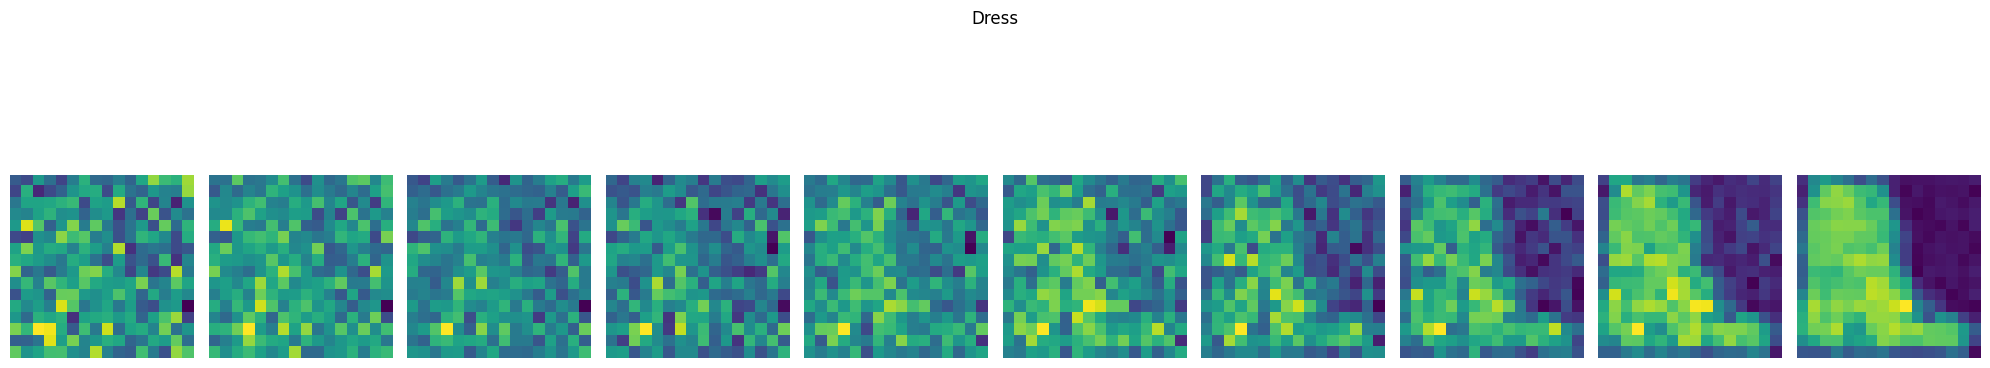

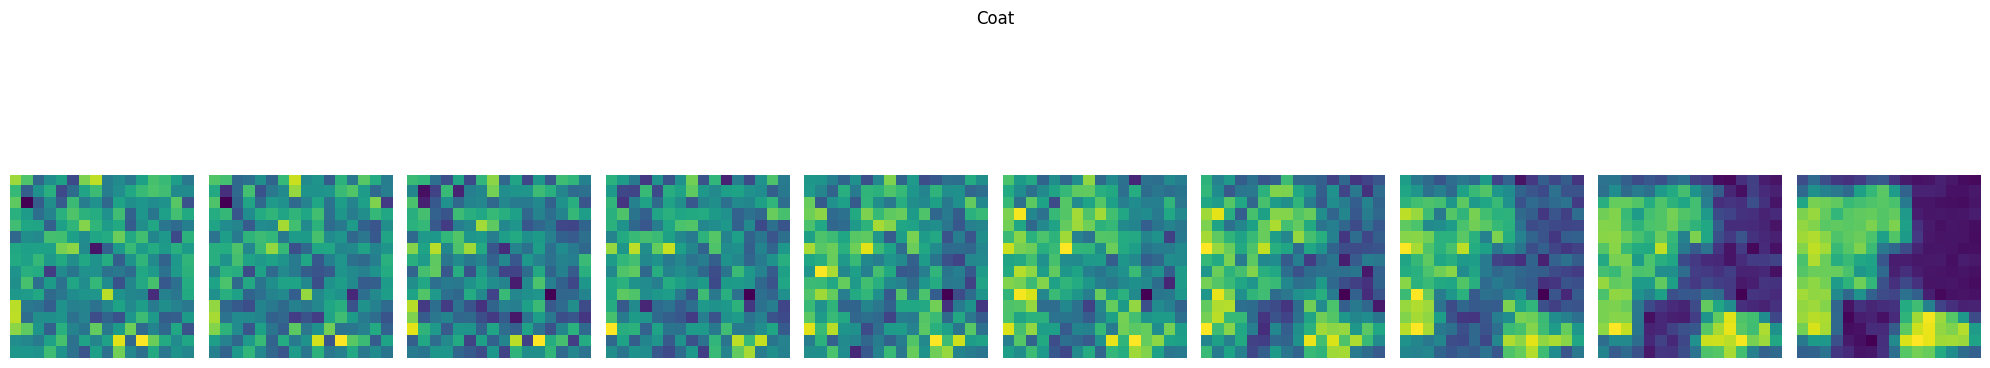

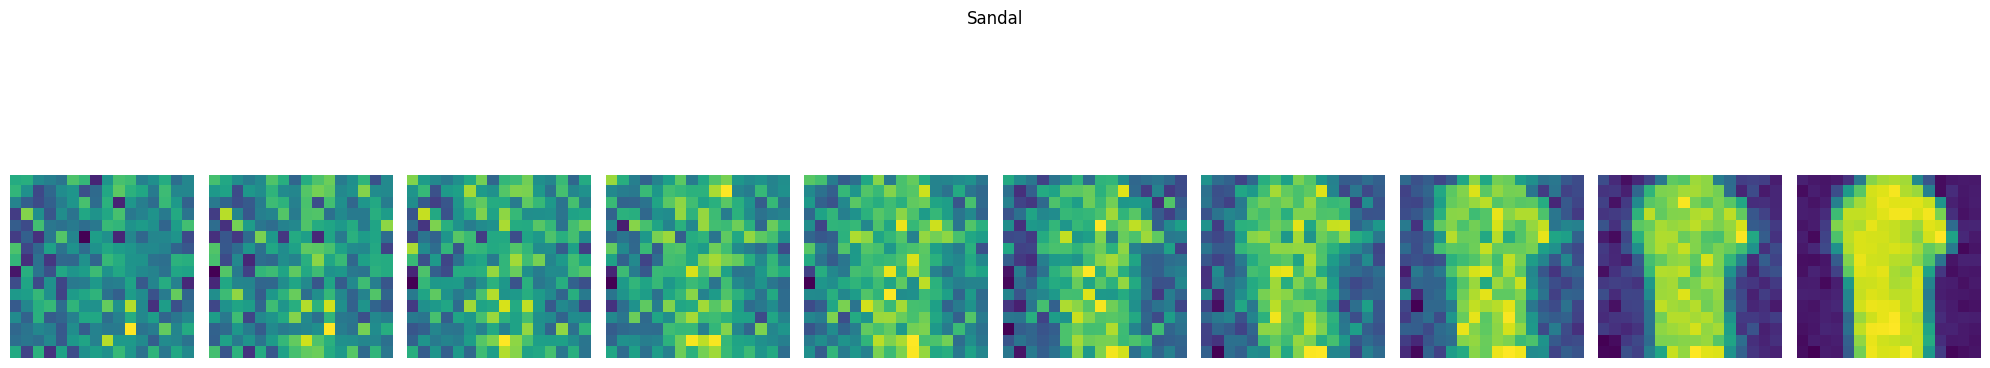

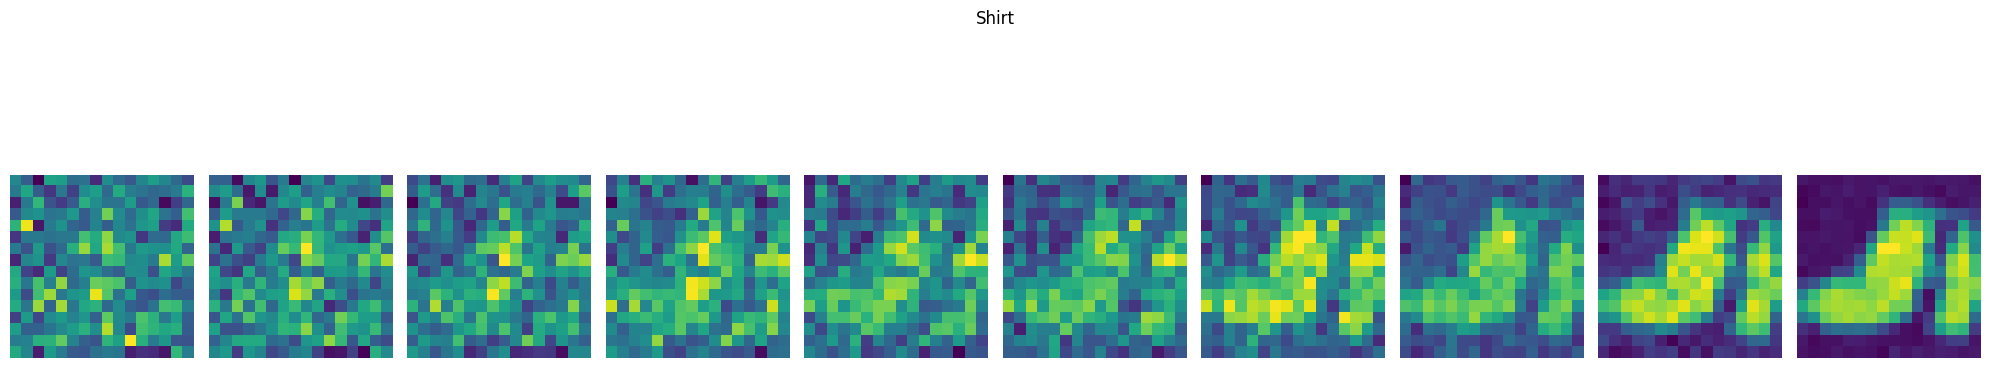

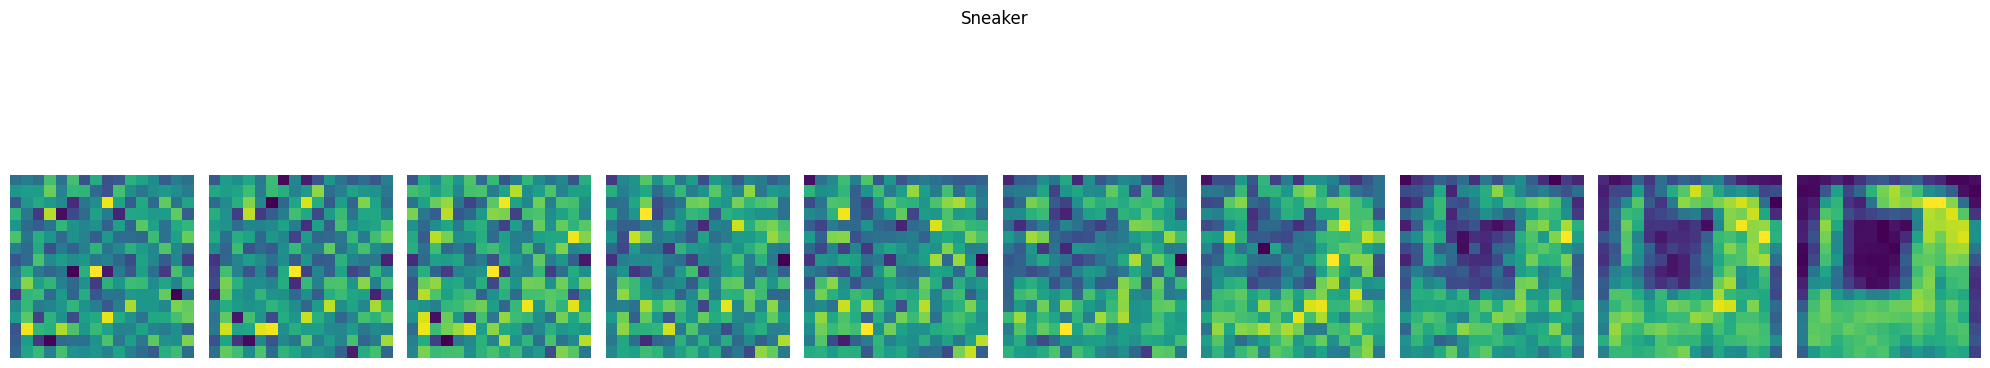

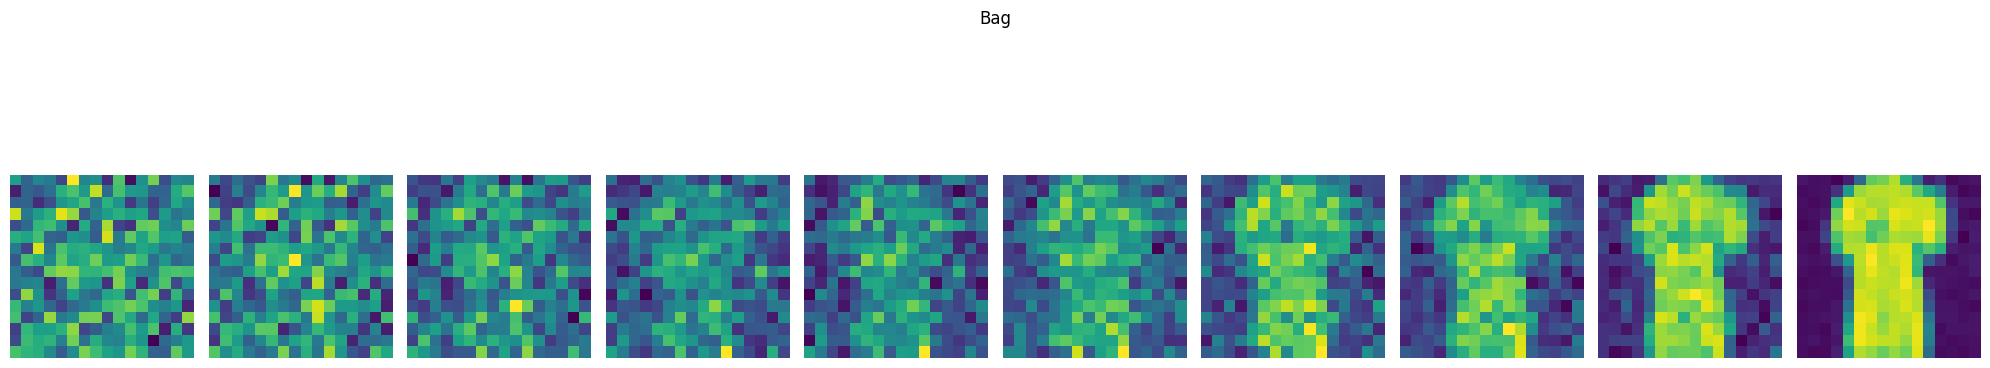

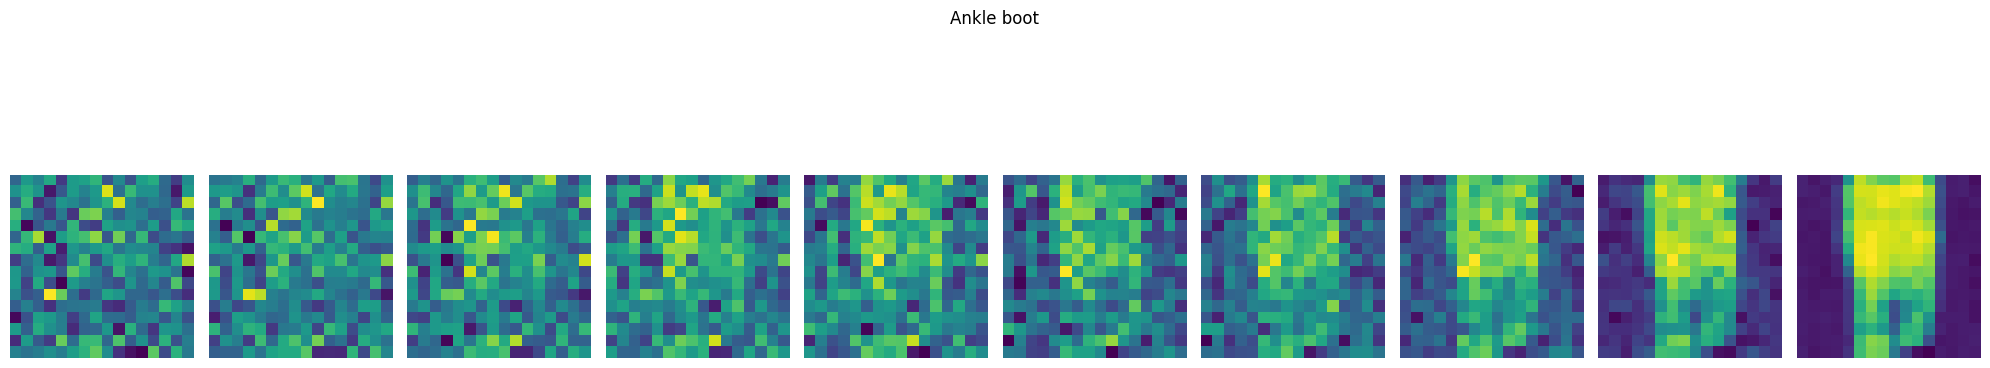

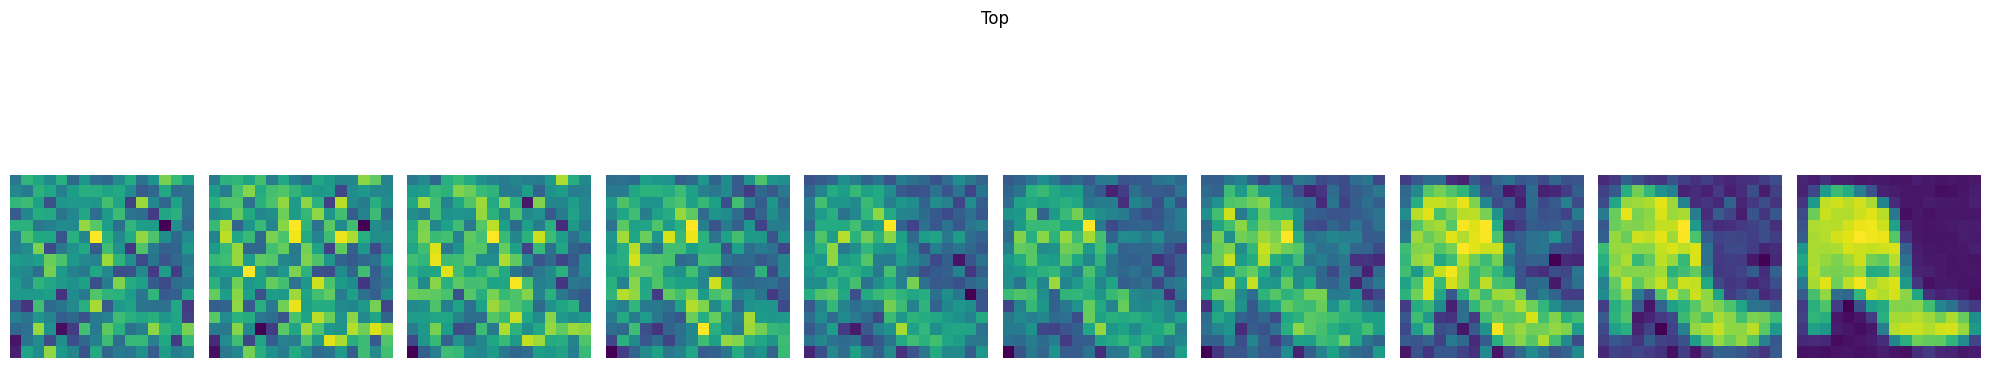

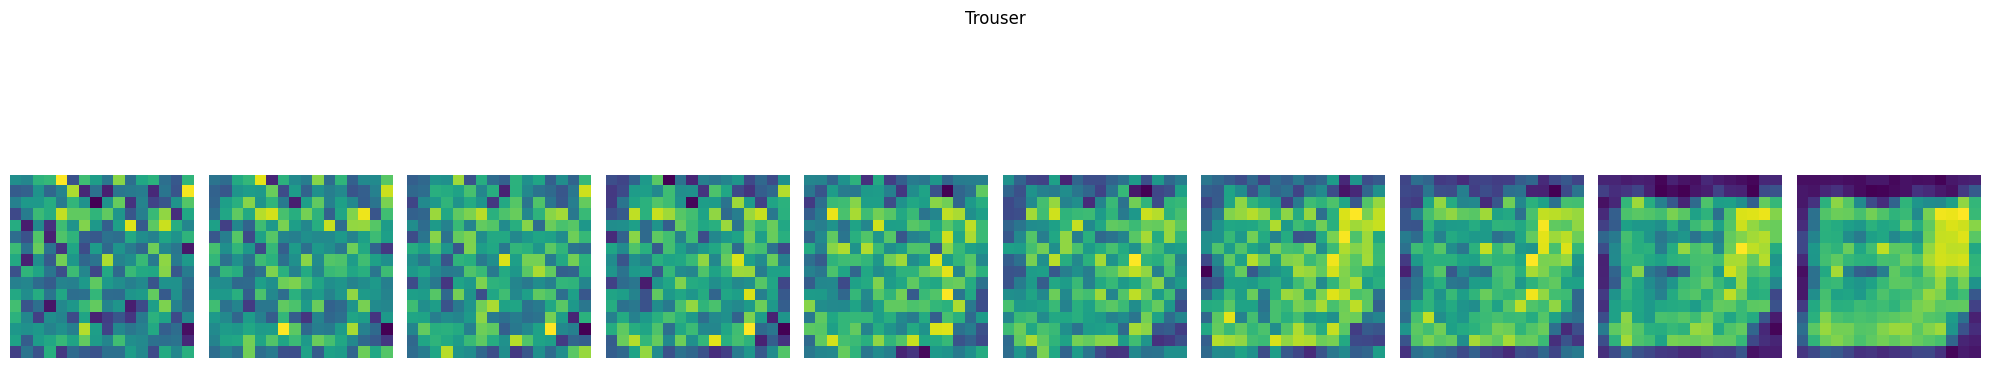

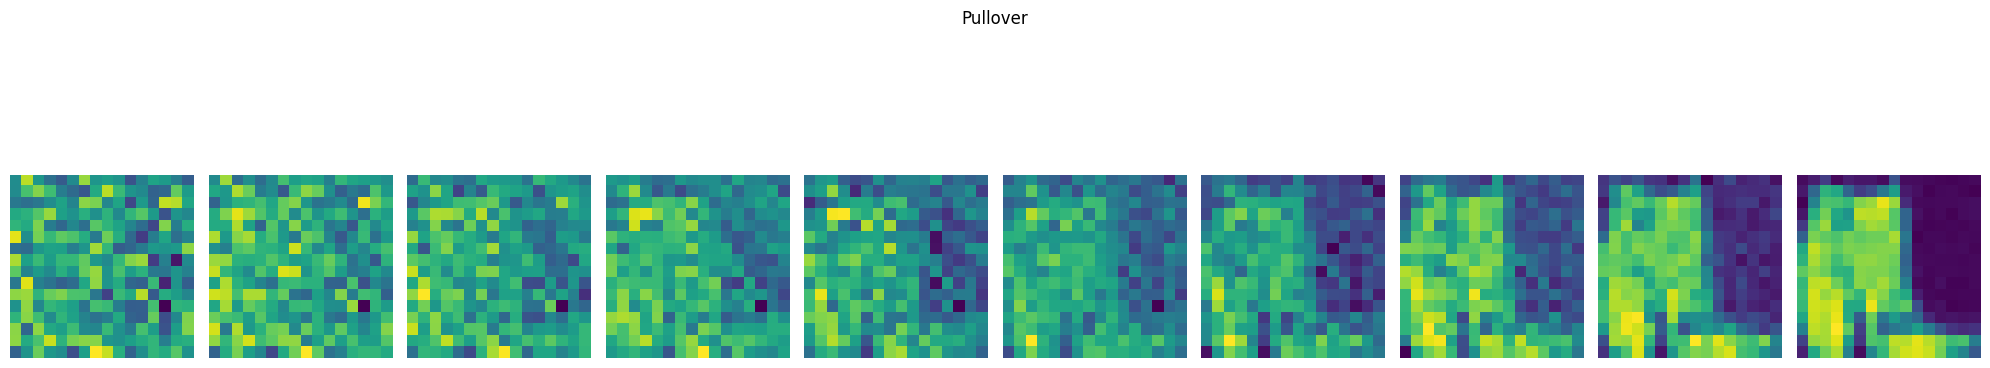

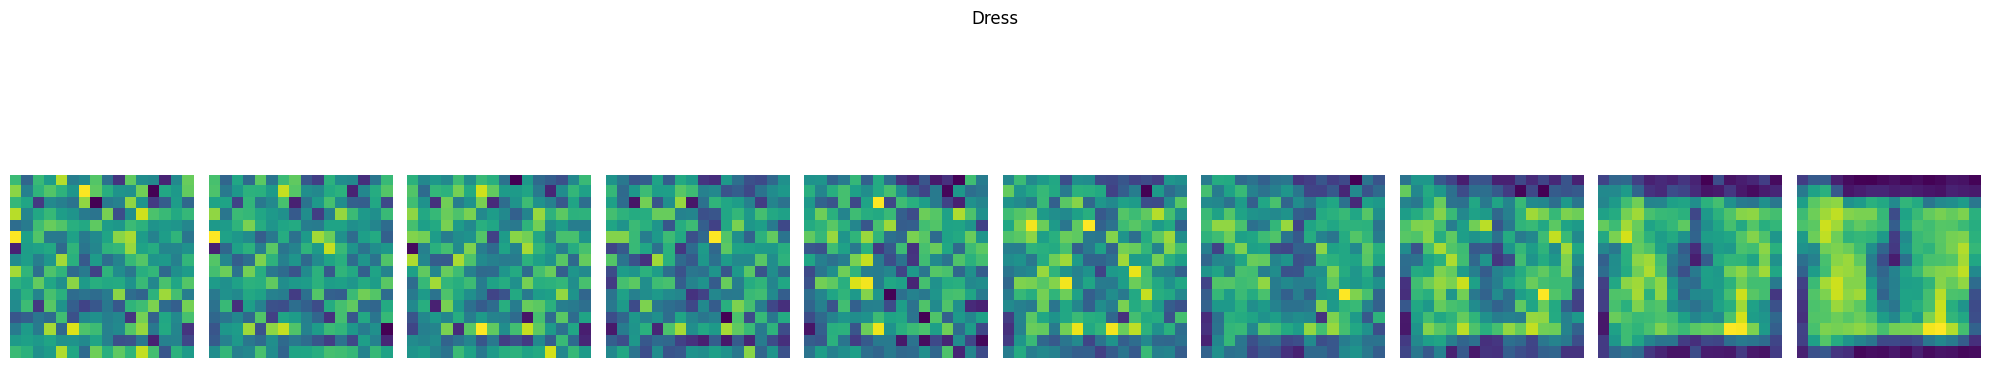

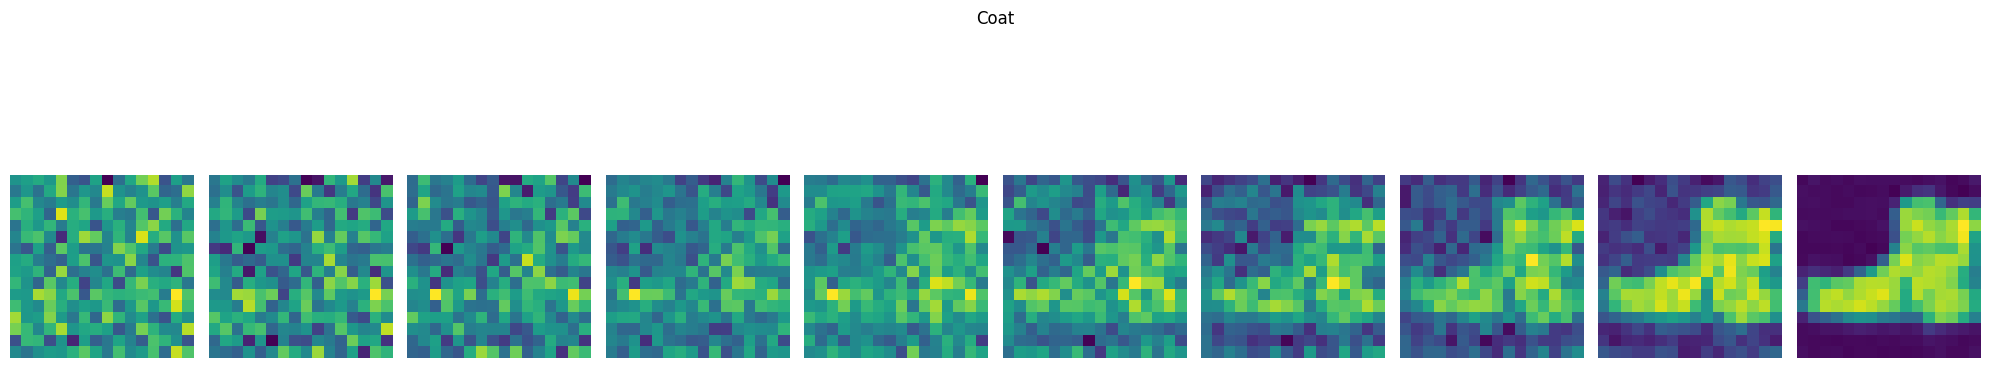

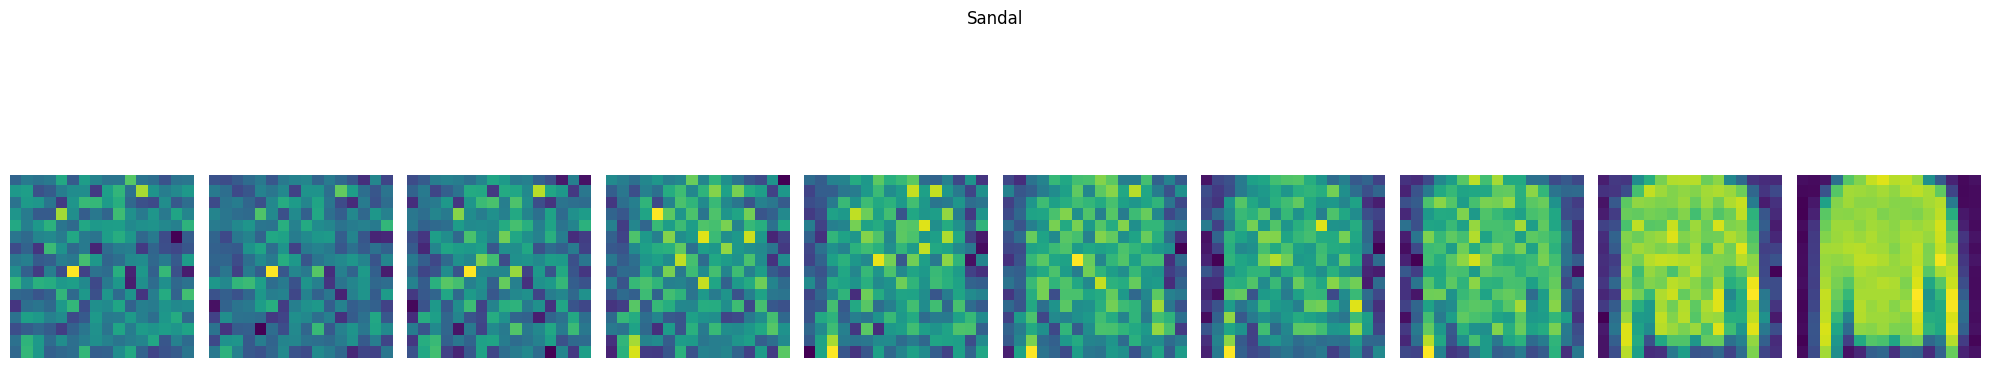

In [6]:
model = UNetv2(IMG_CHANNELS, NUM_CLASSES, down_chs=(16, 32, 64)).to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

i = 1
total_loss = 0
class_ = 0
class_embedder = ClassEmbeddingBlock(10)

for epoch in range(EPOCHS):
    for (x_batch, classes) in dataloader:
        optimizer.zero_grad()

        x_batch = x_batch.to(device)
        classes = classes.to(device)
        rand_times = torch.randint(0, T, (x_batch.shape[0], 1)).to(device)
        noisy_images, noise = utils.forward_diffusion(x_batch, rand_times.squeeze())

        pred_noise = model(noisy_images, rand_times, class_embedder(classes))
        loss = F.mse_loss(noise, pred_noise)

        loss.backward()
        optimizer.step()
        i += 1
        total_loss += loss.item()

        if i % 100 == 0:
            sample_images(15, T, class_, -3)
            class_ += 1
            if class_ > 9:
                class_ = 0